In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %matplotlib widget

In [3]:
import h5py
import librosa

import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

from pathlib import Path
import scipy.signal
import pyroomacoustics as pra
from skimage.restoration import unwrap_phase

import src.utils.dsp_utils as dsp
import src.utils.acu_utils as acu
import src.utils.geo_utils as geo

In [4]:
data_dir = Path('../../../Dataset/SPEAR22/Miscellaneous/Array_Transfer_Functions/Device_ATFs.h5')

# DESCRIPTION: returns dictionary of array's Acoustic Impulse Responses (AIRs) for all measured directions
# *** OUTPUTS ***
# AIR        (dict) dictionary {'IR': (nSample,nDirection,nChannel),'fs': (int),'directions': (N,2),'nChan': (int)}
AIR = {'IR': [],'fs': [],'directions': [],'nChan': [], 'azi': [], 'ele': []}
# IR: (ndarray) Impulse Responses [nSample x nDirection x nChan]
# fs: (int) sample rate in Hz
# directions: (ndarray) (azimuth,elevation) in radians [nDirection x 2] 
# nChan: (int) number of array's sensor/channel
# azi: sorted unique azimuths (radians) [nDirection x 1]
# ele: sorted unique elevations (radians) [nDirection x 1]
f = h5py.File(data_dir,'r')
AIR['fs'] = int(list(f['SamplingFreq_Hz'])[0][0])
AIR['IR'] = np.array(f['IR']) # (ndarray) [nSample x nDirection x nChan]
AIR['ele'] = (np.pi/2)-np.array(f['Theta']) # (ndarray) elevation in radians [1 x nDirection]
AIR['azi'] = np.array(f['Phi']) # (ndarray) azimuth in radians [1 x nDirection]
AIR['directions'] = np.concatenate((AIR['azi'],AIR['ele']),axis=0).T # (ndarray) [nDirection x 2]
AIR['ele'] = np.sort(np.unique(AIR['ele'])) # (ndarray) [nElevation x 1]
AIR['azi'] = np.sort(np.unique(AIR['azi'])) # (ndarray) [nAzimuth x 1]
AIR['nChan'] = AIR['IR'].shape[-1]
f.close()

IR (768, 1020, 6)
ele (17,)
azi (60,)
doa (1020, 2)
[[  0.  84.]
 [  0.  75.]
 [  0.  66.]
 ...
 [354. -48.]
 [354. -57.]
 [354. -66.]]
[[  0.  84.]
 [  0.  75.]
 [  0.  66.]
 ...
 [354. -48.]
 [354. -57.]
 [354. -66.]]
(60, 17, 2)
[ 36. -66.]
[ 36. -66.]


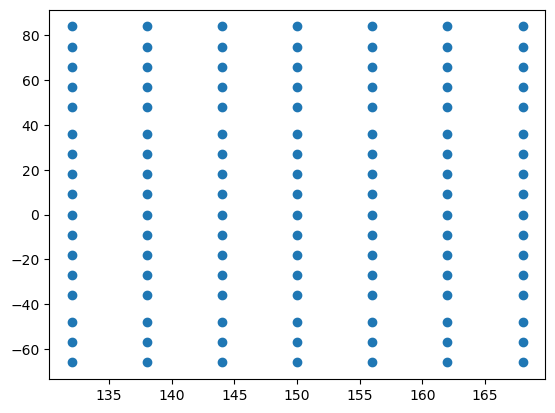

In [5]:
print('IR', AIR['IR'].shape)
print('ele', AIR['ele'].shape)
print('azi', AIR['azi'].shape)
print('doa', AIR['directions'].shape)
print(np.rad2deg(AIR['directions']))

doa = np.rad2deg(AIR['directions'])
print(doa)

n_az = AIR['azi'].shape[0]
n_el = AIR['ele'].shape[0]

doa_grid = doa.reshape(n_az, n_el, 2)
print(doa_grid.shape)
print(doa_grid[6,16,:])
print(doa[6*n_el+16,:])

az, el = np.split(doa, 2, -1)

az_range = [130, 170]

az_idx = (az > az_range[0]) & (az < az_range[1])

plt.scatter(az[az_idx], el[az_idx])
plt.show()

In [6]:
print(np.min(az), np.max(az))
print(np.min(el), np.max(el))

0.0 354.0
-66.00000000000001 84.0


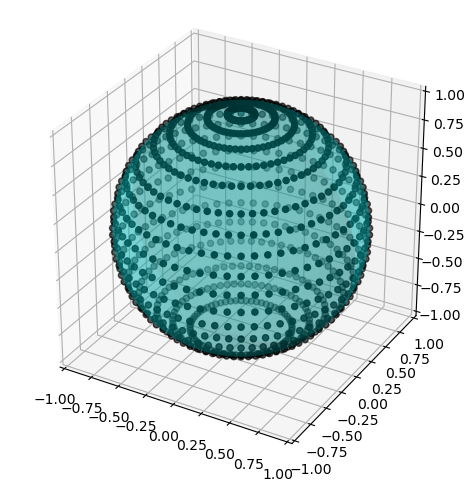

In [7]:
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

# Create a sphere
r = 1
theta, phi = np.mgrid[0.0:np.pi:100j, 0.0:2.0*np.pi:100j]
x = r*np.cos(phi)*np.cos(theta)
y = r*np.cos(phi)*np.sin(theta)
z = r*np.sin(phi)

#Import data
doa = AIR['directions']
az, el = np.split(doa, 2, -1)
# el = np.zeros_like(el)
xx = np.cos(el)*np.cos(az)
yy = np.cos(el)*np.sin(az)
zz = np.sin(el)

#Set colours and render
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(
    x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

ax.scatter(xx,yy,zz,color="k",s=20)

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_box_aspect((1,1,1))
plt.tight_layout()
plt.show()


(3, 6)


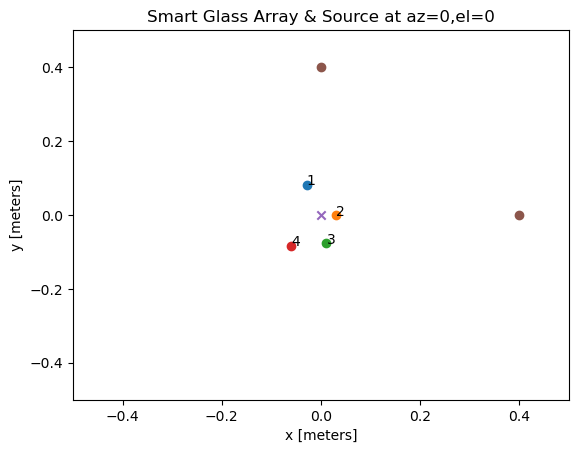

In [8]:
import src.utils.acu_utils as acu

R = acu.get_easycom_array(arr_center=np.zeros([3,1])).mic_pos
print(R.shape)
plt.figure()
x = 0
y = 1
for i in range(4):
    plt.scatter(R[x,i], R[y,i])
    plt.text(   R[x,i], R[y,i], f"{i+1}")

B = np.mean(R, axis=-1)
plt.scatter(0, 0, marker='x')

plt.xlim([-0.50,0.50])
plt.ylim([-0.50,0.50])

az = np.deg2rad(np.array([90, 0]))
el = np.deg2rad(np.array([0, 0]))
r =  0.4
xx = r*np.cos(el)*np.cos(az)
yy = r*np.cos(el)*np.sin(az)

plt.scatter(xx, yy)
plt.title('Smart Glass Array & Source at az=0,el=0')
plt.xlabel("x [meters]")
plt.ylabel("y [meters]")
plt.show()

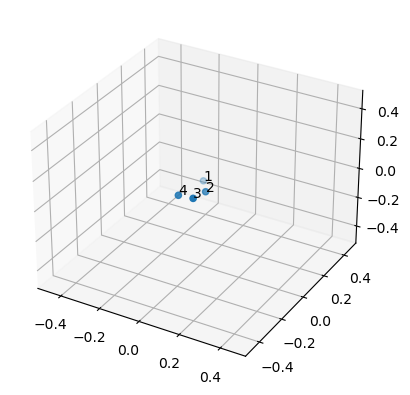

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(R[0,:4], R[1,:4], R[2,:4])
for i in range(4):
    ax.text(R[0,i], R[1,i], R[2,i], f"{i+1}")
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])
ax.set_zlim([-0.5, 0.5])
plt.show()

(768, 1020, 6)


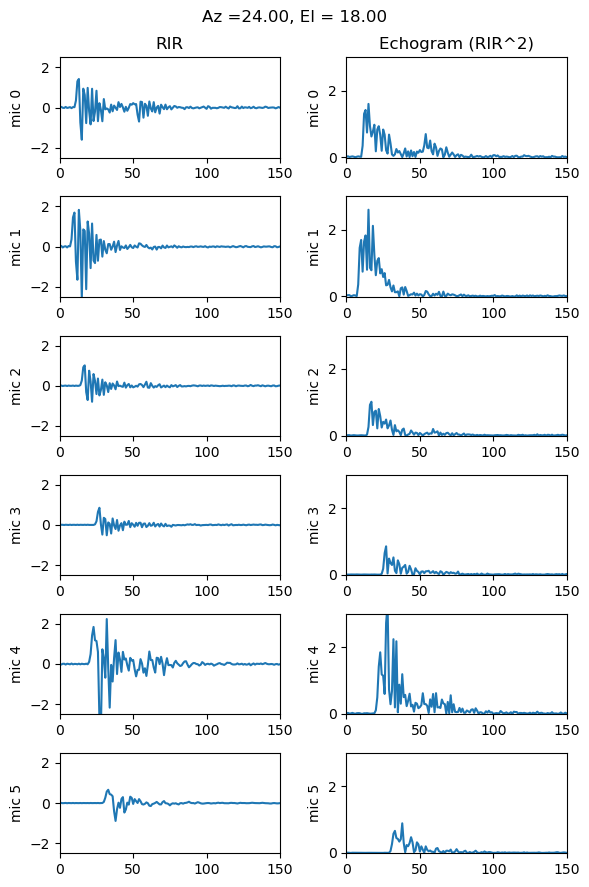

In [10]:
rirs = AIR['IR']
print(rirs.shape)
n = 15*5
az, el = AIR['directions'][n,:]
az = np.rad2deg(az)
el = np.rad2deg(el)

fig, axarr = plt.subplots(6,2,figsize=(6,9))
plt.suptitle(f"Az ={az:1.2f}, El = {el:1.2f}")
for i in range(6):
    axarr[i,0].plot(rirs[:,n,i], label=f'mic {i}')
    axarr[i,0].set_xlim([0,150])
    axarr[i,0].set_ylim([-2.5,2.5])
    axarr[i,0].set_ylabel(f"mic {i}")
    
    axarr[i,1].plot(np.abs(rirs[:,n,i]), label=f'mic {i}')
    axarr[i,1].set_xlim([0,150])
    axarr[i,1].set_ylim([-0.01, 3])
    axarr[i,1].set_ylabel(f"mic {i}")
    
axarr[0,0].set_title("RIR")
axarr[0,1].set_title("Echogram (RIR^2)")
    
plt.tight_layout()
plt.show()

(768, 1020, 6)
torch.complex64
torch.Size([1025, 6])
1025
torch.Size([2048, 6])
torch.Size([768, 6])
False
tensor([[3.4925e-09, 6.7521e-09, 1.0245e-08, 1.1176e-08, 1.6764e-08, 1.1642e-08],
        [0.0000e+00, 7.4506e-09, 6.5193e-09, 0.0000e+00, 3.7253e-09, 1.3970e-09],
        [3.2596e-09, 1.8626e-09, 2.7940e-09, 6.0536e-09, 1.8626e-09, 9.3132e-10],
        ...,
        [1.1642e-09, 6.9849e-10, 5.1223e-09, 1.8626e-08, 1.3271e-08, 6.8685e-09],
        [1.8626e-09, 2.5611e-09, 5.1223e-09, 1.0943e-08, 6.9849e-09, 4.6566e-09],
        [9.3132e-10, 6.2864e-09, 2.3283e-10, 5.5879e-09, 9.3132e-10, 1.1176e-08]])


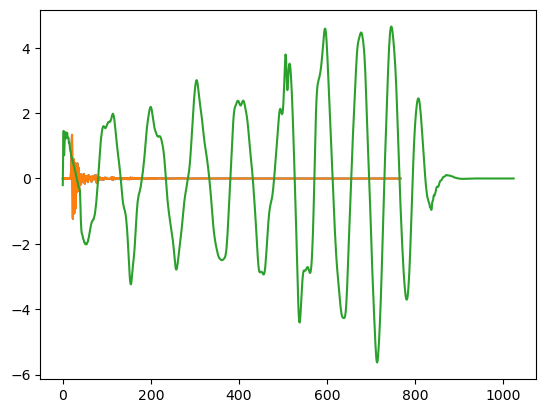

In [11]:
print(rirs.shape)
_air = rirs[:,34,:] # n_smpl x n_chan
import torch

_air = torch.from_numpy(_air).float()
nsmpl = _air.shape[0]
nrfft = 1025
_atf = torch.fft.rfft(_air, 2*(nrfft-1), dim=0)
print(_atf.dtype)
print(_atf.shape)
print(nrfft)
__air = torch.fft.irfft(_atf, n=2*(nrfft-1), dim=0)
print(__air.shape)
__air = __air[:nsmpl,:].real
print(__air.shape)

plt.plot(_air[:,0].numpy())
plt.plot(__air[:,0].numpy())

print(torch.allclose(__air, _air))
print(torch.abs(__air - _air))

plt.plot(_atf.real[:,0].numpy())

(768, 1020, 6)


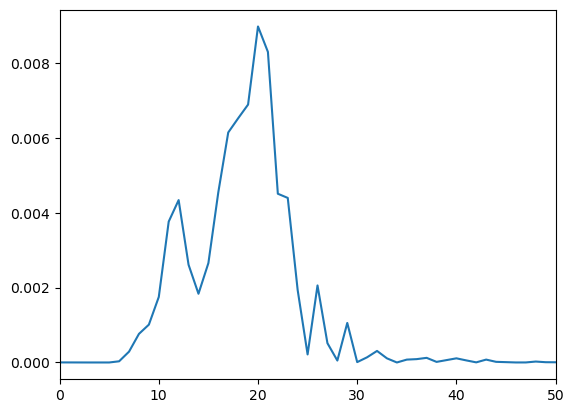

In [12]:
rirs = AIR['IR']
print(rirs.shape)

plt.figure()
plt.plot(rirs[:,:,:4].mean(-1).mean(-1)**2)
plt.xlim([0,50])
plt.show()

[[ 8.25655977  0.          2.65889213 12.59475219  8.25655977 12.59475219]]
[ 8.  0.  3. 13.]
[ 8.  0.  3. 13.]
AZ: [358.]
AZ: [0.]
9


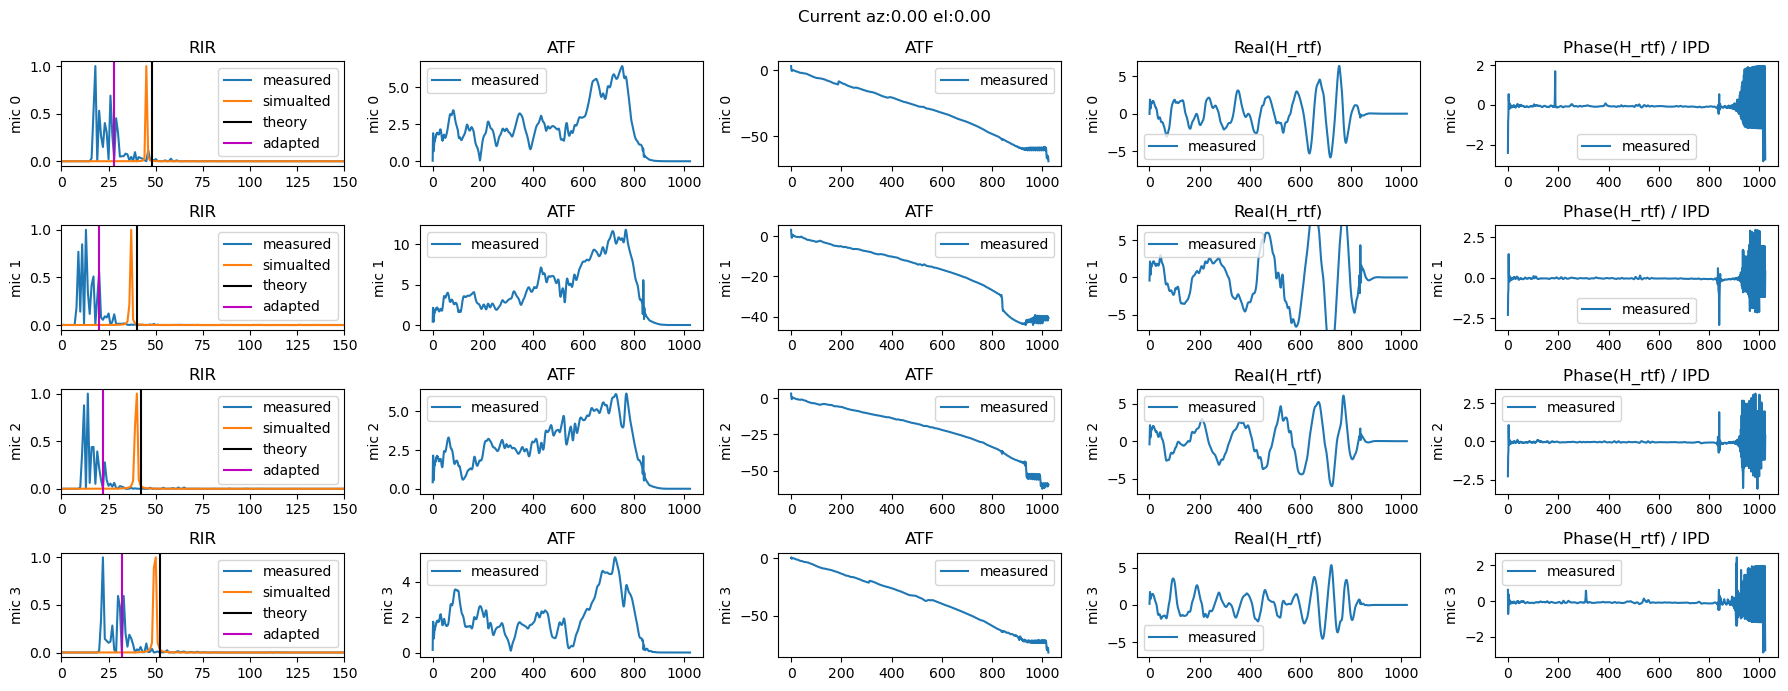

[[-11.61516035   0.          10.63556851  11.47521866 -11.61516035
   11.47521866]]
[-12.   0.  11.  11.]
[-12.   0.  11.  12.]
AZ: [103.]
AZ: [90.]
264


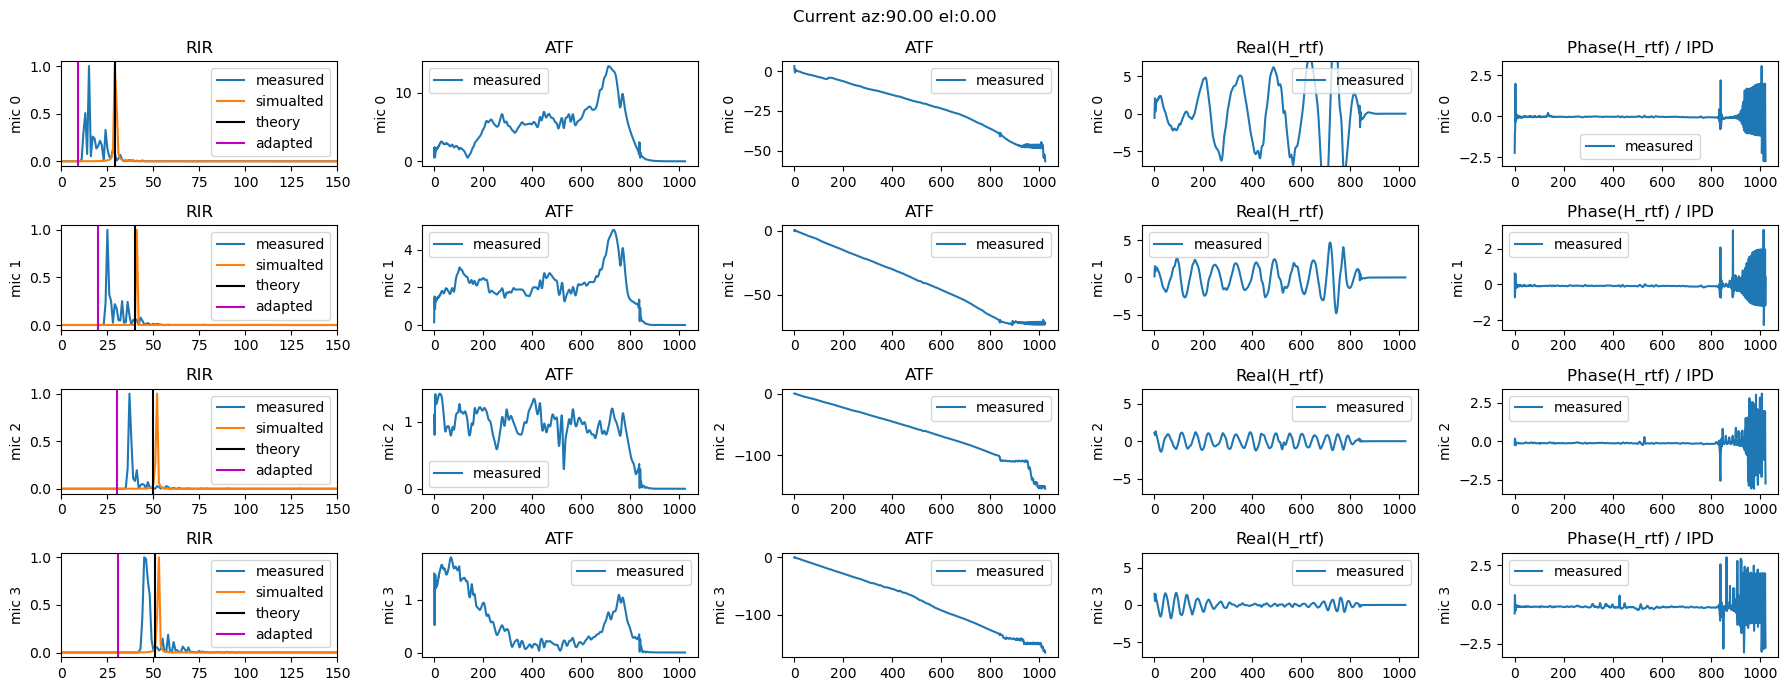

[[ -8.25655977   0.          -2.65889213 -12.59475219  -8.25655977
  -12.59475219]]
[ -8.   0.  -3. -13.]
[ -8.   0.  -2. -12.]
AZ: [174.]
AZ: [180.]
519


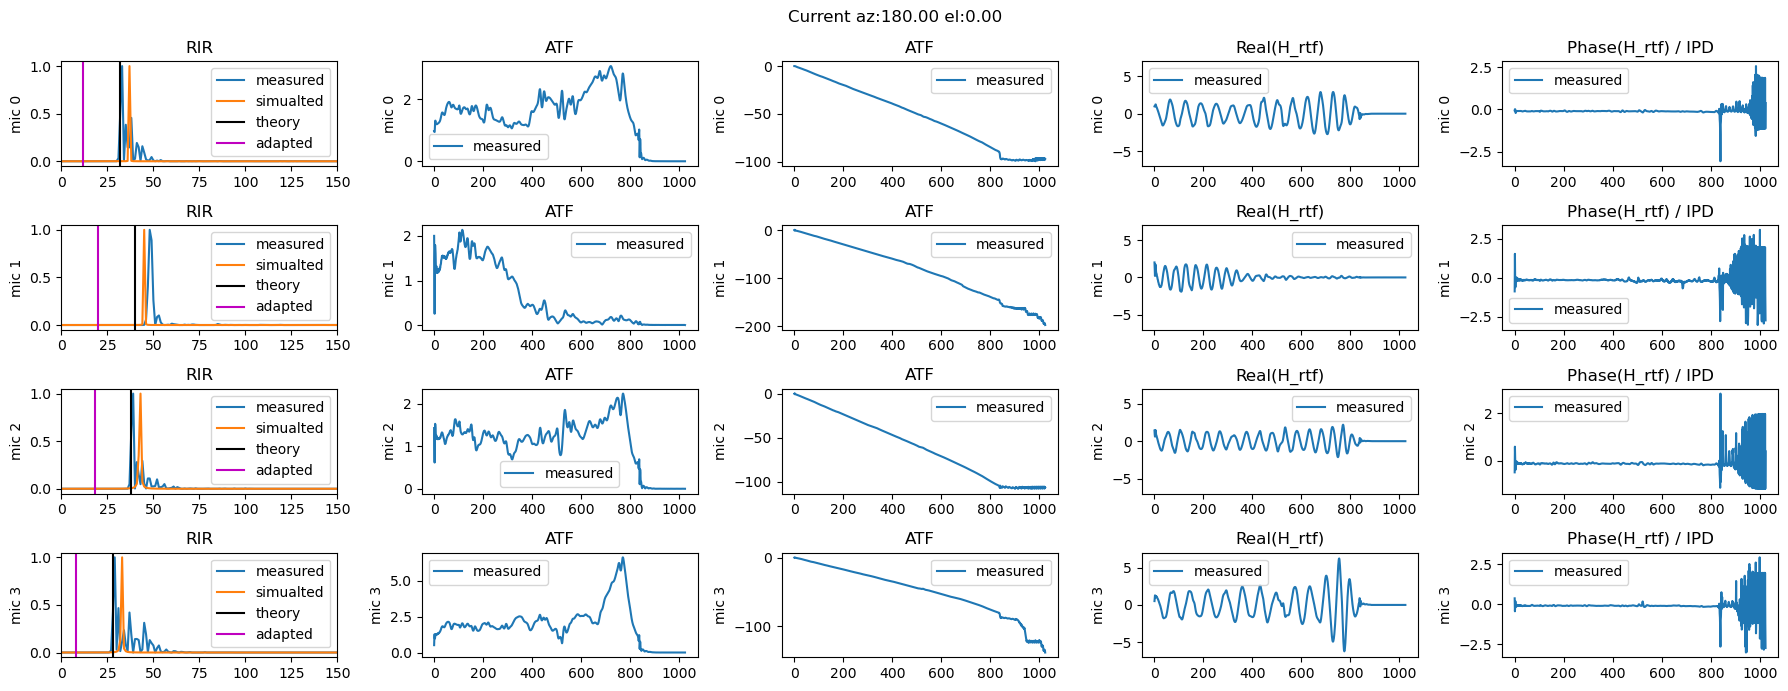

[[ 11.61516035   0.         -10.63556851 -11.47521866  11.61516035
  -11.47521866]]
[ 12.   0. -11. -11.]
[ 12.   0. -11. -11.]
AZ: [275.]
AZ: [270.]
774


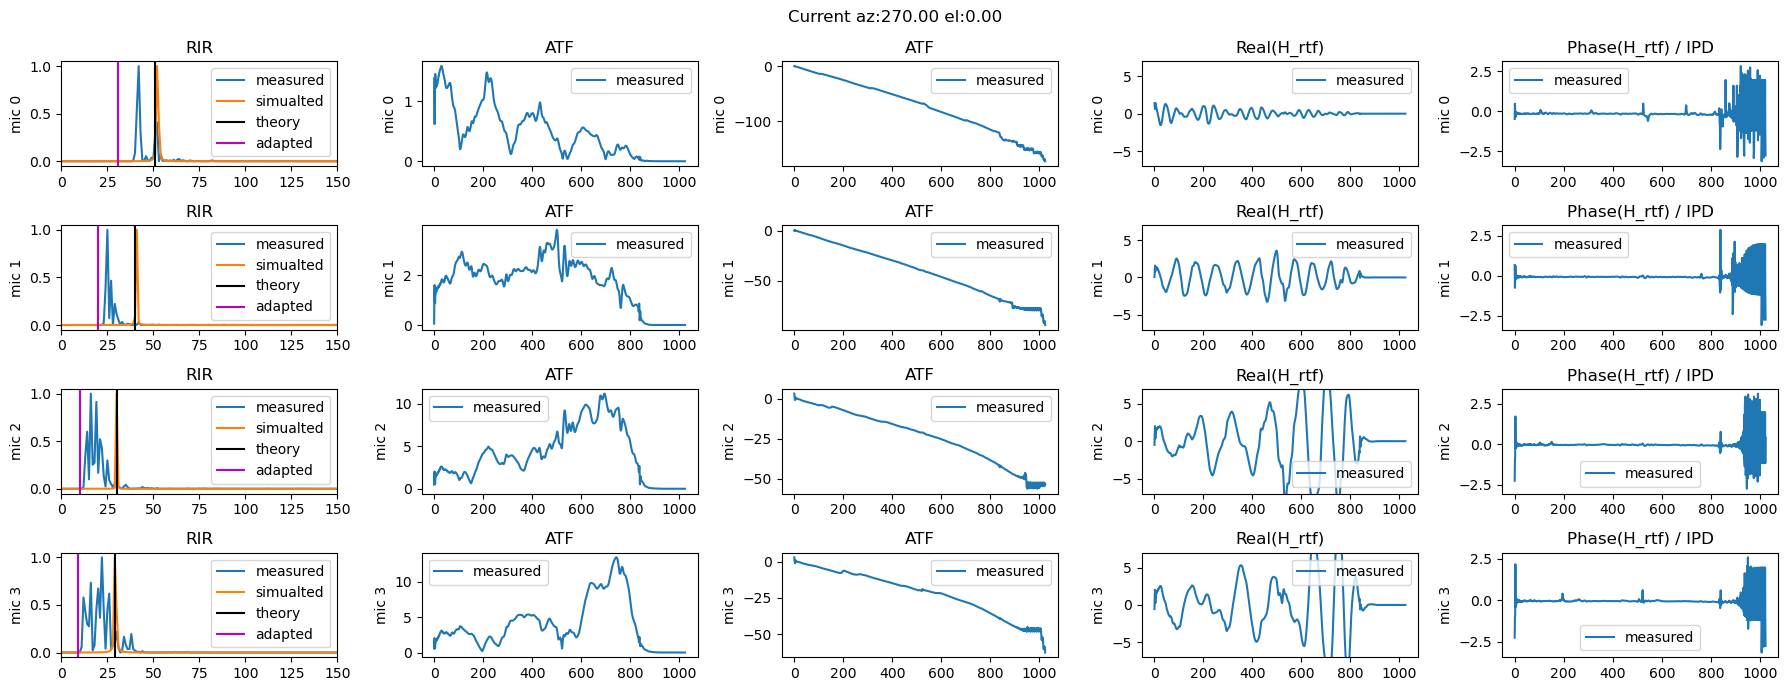

In [13]:
n_rirs = rirs.shape[1]
n_mics = rirs.shape[-1]
fs = AIR['fs']
ref_mic = 1
nfft = 1024


for n in range(n_rirs):
    
    # far field model
    az, el = AIR['directions'][n,:]
    
    if not np.rad2deg(el) in  [0]:
        continue
    
    if not np.rad2deg(az) in  [0, 90, 180, 270]:
        continue
    
    # MEASURED RIRs
    _airs_measured = AIR['IR'][:,n,:]
    _atfs_measured = np.fft.rfft(AIR['IR'][:,n,:], n=2048, axis=0)[:1025,:]

    ## RTF estimation
    x = np.random.randn(fs//2)
    I = _airs_measured.shape[-1]
    y_measured = np.concatenate([np.convolve(x, _airs_measured[:,i])[:,None] for i in range(I)], axis=-1)
    Y_measured = librosa.stft(y_measured.T, n_fft=nfft, center=False)
    rtfs_measured = np.mean(Y_measured / Y_measured[ref_mic,:,:][None,:,:], axis=-1).T

    # SYNTH RIRs
    arr_center = np.array([[3],[3],[3]])
    R = acu.get_easycom_array(arr_center=arr_center).mic_pos
    array_pos = R + arr_center
    
    source_pos = geo.sph2cart(np.array([[2],[az],[el]]), deg=False)
    source_pos = arr_center + source_pos

    ## Pyroom simulation
    pol = np.array([[0,0], [0,6], [6,6], [6,0]]).T
    room = pra.Room.from_corners(pol, fs=fs, max_order=1,materials=pra.Material(.99, 0.))
    room.extrude(5., materials=pra.Material(.99,0.))
    ### Adding the microphone
    room.add_microphone_array(pra.MicrophoneArray(array_pos, room.fs))
    ### Adding the source
    room.add_source(source_pos)

    # fig, ax = room.plot()
    # ax.set_xlim([0, 8])
    # ax.set_ylim([0, 8])
    # ax.set_zlim([0, 4])
    # plt.show()

    room.compute_rir()
    _rirs = room.rir

    
    L = fs//2
    y = np.concatenate([np.convolve(x, _rirs[i][0])[:L,None] for i in range(I)], axis=-1)
    Y_simulated = librosa.stft(y.T, n_fft=nfft, center=False)
    rtfs_simulated = np.mean(Y_simulated / Y_simulated[ref_mic,:,:][None,:,:], axis=-1).T


    # THEORETICAL MODELs
    f = np.linspace(0, fs//2, nfft//2+1,endpoint=True)
    dist_from_ref = R - R[:,ref_mic][:,None]
    vect_theta = -1 * geo.sph2cart(np.array([[1],[az],[el]]), deg=False) # change directiom for pointing towards the array
    
    tof = np.linalg.norm(source_pos - arr_center)/room.c
    tof = int(fs * tof)
    
    # TIMEs of ARRIVAL
    toas_far = (dist_from_ref.T @ vect_theta).T / room.c
    print(toas_far * 48000)
    ## near-fieal (cartesian)
    src_to_mics_dist = np.linalg.norm(source_pos - array_pos, axis=0, keepdims=True)
    toas_close = (src_to_mics_dist - src_to_mics_dist[:,ref_mic,None]) / room.c
    print(np.round(fs * toas_far.squeeze()[:4]))
    print(np.round(fs * toas_close.squeeze()[:4]))

    
    ## doa-based method (free far field)
    rtfs_synth = np.exp(-1j*2*np.pi*f[:,None]* toas_far)
    # rtfs_synth = np.exp(-1j*2*np.pi*f[:,None]* toas_close)
    
    ## Double check with SSL
    doa = pra.doa.algorithms['SRP'](array_pos, fs, nfft)
    for y in [Y_measured,Y_simulated]:
        doa.locate_sources(y)
        # evaluate result
        print("AZ:", np.rad2deg(doa.azimuth_recon))

    
    scale = lambda x : x / np.max(np.abs(x))
    # scale  = lambda x : x 
    
    print(n)
    
    fig, axarr = plt.subplots(4, 5, figsize=(18,7))
    plt.suptitle(f'Current az:{np.rad2deg(az):1.2f} el:{np.rad2deg(el):1.2f}')
    for i in range(4):
        
        j = 0
        axarr[i,j].plot(scale(_airs_measured[:,i])**2, label='measured')
        axarr[i,j].plot(scale(_rirs[i][0][tof:]**2), label="simualted")
        axarr[i,j].axvline(x=int(fs * toas_close.squeeze()[i]) + 40, color='k', label="theory")
        axarr[i,j].axvline(x=int(fs * toas_far.squeeze()[i]) + 20, color='m', label='adapted')
        axarr[i,j].set_ylabel(f'mic {i}')
        axarr[i,j].set_xlim([0, 150])
        axarr[i,j].set_title('RIR')
        axarr[i,j].legend()
        
        j += 1
        axarr[i,j].plot(np.abs(np.fft.rfft(_airs_measured[:,i], 2048)), label="measured")
        axarr[i,j].set_ylabel(f'mic {i}')
        axarr[i,j].set_title('ATF')
        axarr[i,j].legend()

        j += 1
        axarr[i,j].plot(unwrap_phase(np.angle(np.fft.rfft(_airs_measured[:,i], 2048))), label="measured")
        axarr[i,j].set_ylabel(f'mic {i}')
        axarr[i,j].set_title('ATF')
        axarr[i,j].legend()

        j += 1
        # axarr[i,j].plot(np.real(atfs_synth[:,i]), label='theory')
        axarr[i,j].plot(np.real(_atfs_measured[:,i]), label='measured')
        # axarr[i,j].plot(np.real(rtfs_simul_ated[:,i]), label='simulated')
        axarr[i,j].set_ylabel(f'mic {i}')
        axarr[i,j].set_ylim([-7,7])
        axarr[i,j].legend()
        axarr[i,j].set_title('Real(H_rtf)')
        
        j += 1
        # axarr[i,j].plot(unwrap_phase(np.angle(rtfs_synth[1:,i])), label='theory')
        axarr[i,j].plot(np.diff(unwrap_phase(np.angle(_atfs_measured[0:,i]))), label='measured')
        # axarr[i,j].plot(unwrap_phase(np.angle(rtfs_simulated[1:,i])), label='simulated')
        # axarr[i,j].set_ylim([-60,60])
        axarr[i,j].set_ylabel(f'mic {i}')
        axarr[i,j].legend()
        axarr[i,j].set_title('Phase(H_rtf) / IPD')
        
    plt.tight_layout()
    plt.show()

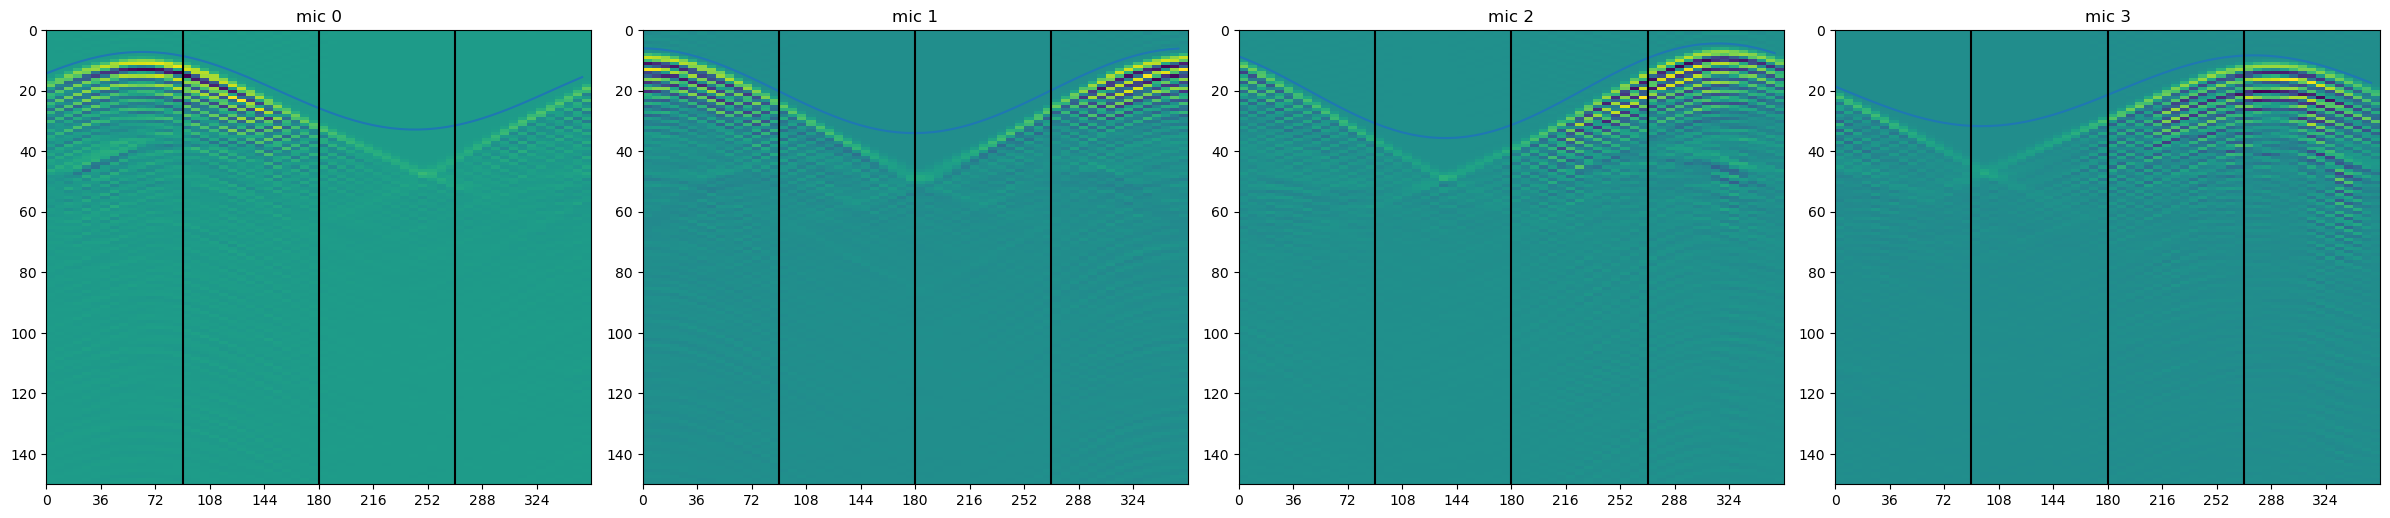

[ -5.73760933  -6.90566508  -7.99806091  -9.00282832  -9.90895886
 -10.70652477 -11.38678775 -11.9422947  -12.36695938 -12.65612906
 -12.80663554 -12.81682984 -12.68660027 -12.41737366 -12.0120997
 -11.47521866 -10.81261272 -10.03154154  -9.14056269  -8.14943792
  -7.06902621  -5.91116476  -4.68853936  -3.41454534  -2.10314084
  -0.76869389   0.57417502   1.91075316   3.22639669   4.50669113
   5.73760933   6.90566508   7.99806091   9.00282832   9.90895886
  10.70652477  11.38678775  11.9422947   12.36695938  12.65612906
  12.80663554  12.81682984  12.68660027  12.41737366  12.0120997
  11.47521866  10.81261272  10.03154154   9.14056269   8.14943792
   7.06902621   5.91116476   4.68853936   3.41454534   2.10314084
   0.76869389  -0.57417502  -1.91075316  -3.22639669  -4.50669113]
[[ 0.9945219 ]
 [-0.10452846]
 [ 0.        ]]


In [24]:
airs_az = []
atfs_az = []
tofs_bar = []
tofs_arr = []
tofs_mdl = []
azimuths = []

nfft = 2048
nrfft = nfft//2 + 1

for n in range(n_rirs):
    
    # far field model
    az, el = AIR['directions'][n,:]
    
    if not np.rad2deg(el) == 0:
        continue
    
    airs_az.append(AIR['IR'][:,n,:])
    atfs_az.append(np.fft.rfft(AIR['IR'][:,n,:], n=nfft, axis=0)[:1025,:])
    
    # far field model
    freqs = np.linspace(0, fs//2, nrfft, endpoint=True)
    # dist_from_ref = -(R - np.mean(R[:,:4], axis=-1, keepdims=True)) #np.zeros((3,1))
    dist_from_ref = -(R - np.array([[-0.07,-0.00,0]]).T)
    vect_mics = dist_from_ref
    
    # az += np.deg2rad(45)  
    vect_theta = geo.sph2cart(np.array([[1],[az],[el]]), deg=False) # change directiom for pointing towards the array

    # TIMEs of ARRIVAL
    toas_far = (vect_mics.T @ vect_theta).T / room.c
    
    tofs_mdl.append(toas_far)
    azimuths.append(az)
    
airs_az = np.stack(airs_az, axis=1)
atfs_az = np.stack(atfs_az, axis=1)
toas_mdl = np.stack(tofs_mdl, axis=0)
azimuths = np.stack(azimuths, axis=0)


# print(airs_az.shape)
# print(atfs_az.shape)
# print(toas_mdl.shape)
# print(azimuths.shape)

# print(np.rad2deg(azimuths))

n_smpl, n_az, n_mic = airs_az.shape  

n_mics = 4
fig, axarr = plt.subplots(1, n_mics, figsize=(24,24))
for i, ax in enumerate(axarr):
    ax.set_title(f'mic {i}')
    ax.imshow(airs_az[:150, :, i], extent=[0,360,150,0], aspect=2)
    ax.set_xticks(np.rad2deg(azimuths)[::6])
    ax.plot(np.rad2deg(azimuths), toas_mdl[:,:,i] * fs + 20)
    # ax.axhline(y=20, c='k')
    ax.axvline(x=90, c='k')
    ax.axvline(x=180, c='k')
    ax.axvline(x=270, c='k')
    
plt.tight_layout()
plt.show()

print(toas_mdl[:,0,0] * fs)
print(vect_theta)


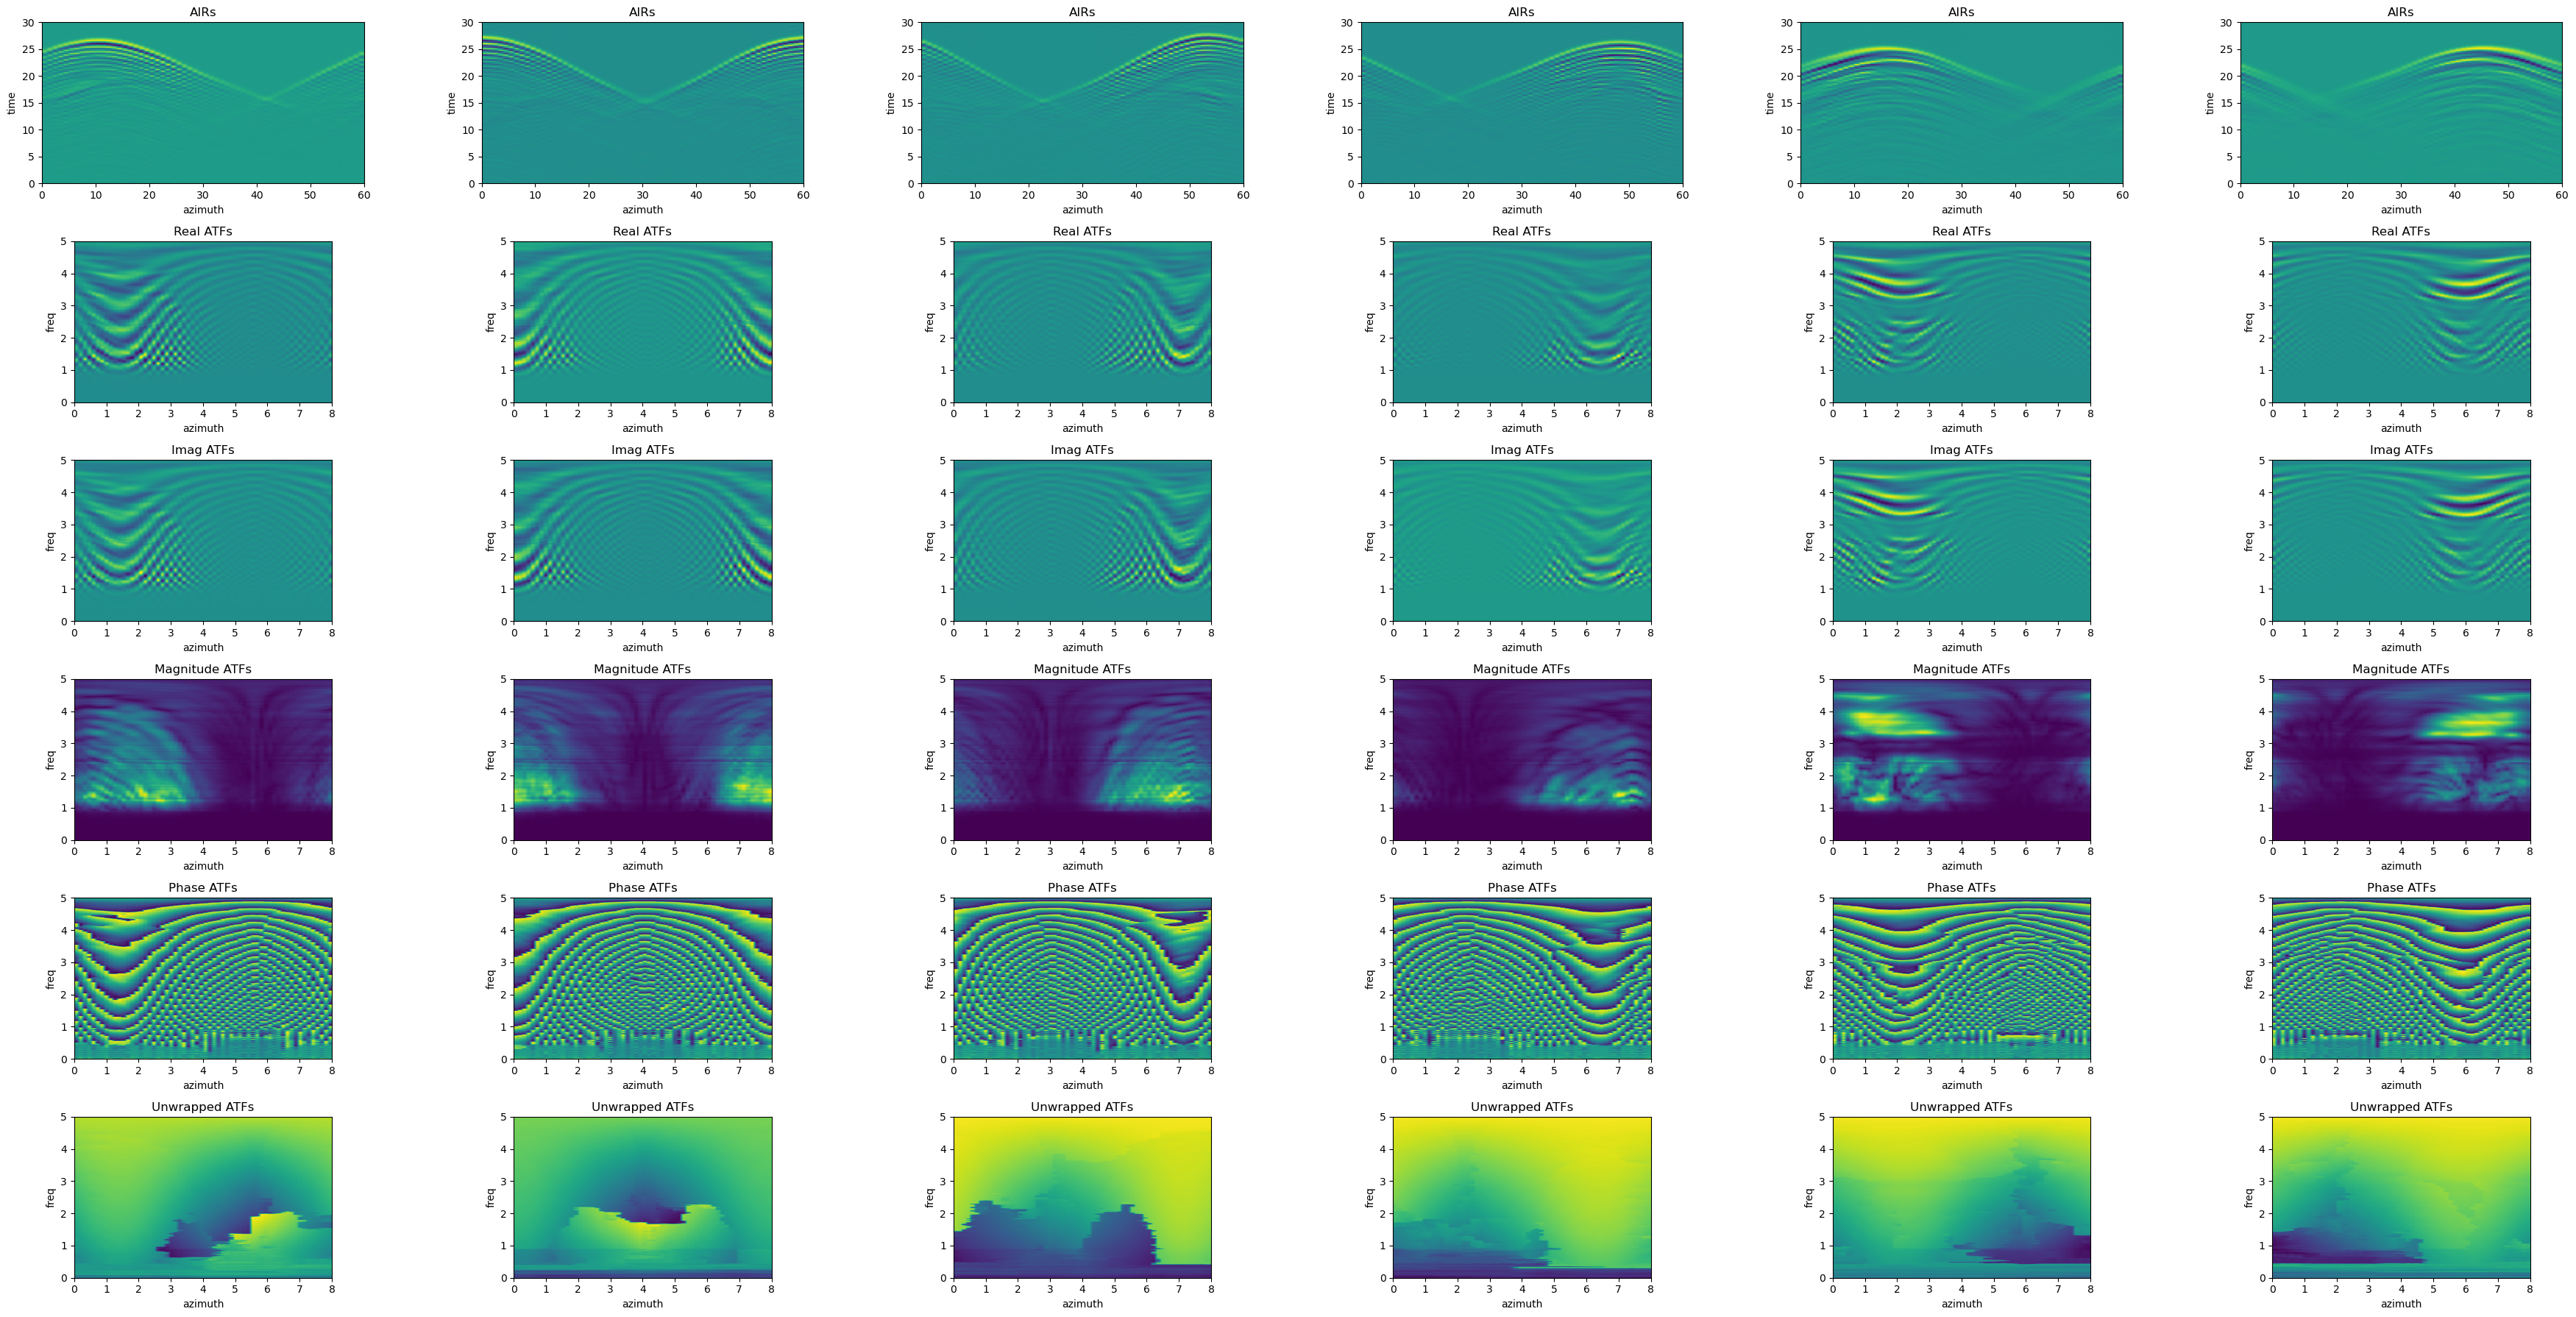

In [15]:
n_smpl, n_az, n_mic = airs_az.shape  
fig, axarr = plt.subplots(6, n_mic, figsize=[6*n_mic, 6*3])
for i in range(n_mic):
    axarr[0, i].imshow(airs_az[:100,:,i], extent=[0, n_az, 0, n_az//2])
    axarr[0, i].set_title('AIRs')
    axarr[0, i].set_xlabel('azimuth')
    axarr[0, i].set_ylabel('time')
    
    axarr[1, i].imshow(atfs_az[:,:,i].real, extent=[0, 8, 0, 5])
    axarr[1, i].set_title('Real ATFs')
    axarr[1, i].set_xlabel('azimuth')
    axarr[1, i].set_ylabel('freq')
    
    axarr[2, i].imshow(atfs_az[:,:,i].imag, extent=[0, 8, 0, 5])
    axarr[2, i].set_title('Imag ATFs')
    axarr[2, i].set_xlabel('azimuth')
    axarr[2, i].set_ylabel('freq')
    
    axarr[3, i].imshow(np.abs(atfs_az[:,:,i]), extent=[0, 8, 0, 5])
    axarr[3, i].set_title('Magnitude ATFs')
    axarr[3, i].set_xlabel('azimuth')
    axarr[3, i].set_ylabel('freq')
    
    axarr[4, i].imshow(np.angle(atfs_az[:,:,i]), extent=[0, 8, 0, 5])
    axarr[4, i].set_title('Phase ATFs')
    axarr[4, i].set_xlabel('azimuth')
    axarr[4, i].set_ylabel('freq')
    
    axarr[5, i].imshow(unwrap_phase(np.angle(atfs_az[:,:,i])), extent=[0, 8, 0, 5])
    axarr[5, i].set_title('Unwrapped ATFs')
    axarr[5, i].set_xlabel('azimuth')
    axarr[5, i].set_ylabel('freq')
plt.tight_layout()
plt.show()


(1025, 1025)


Text(0, 0.5, 'freq')

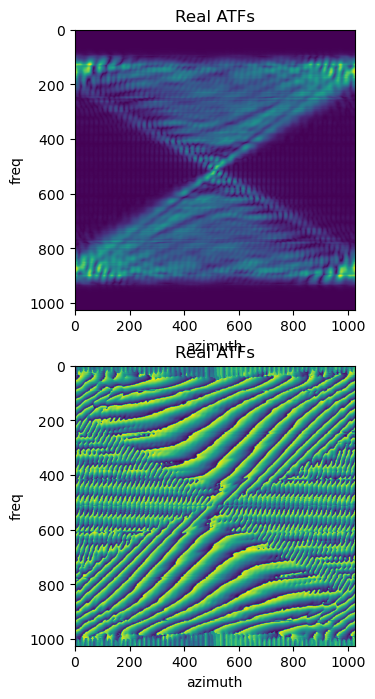

In [16]:
rir_matrix = airs_az[:,:,0]
rir_matrix_fft = np.fft.fftshift(np.fft.fft2(rir_matrix, s=[1025,1025]))
print(rir_matrix_fft.shape)

fig, axarr = plt.subplots(2,1, figsize=(8,8))
axarr[0].imshow(np.abs(rir_matrix_fft))
axarr[0].set_title('Real ATFs')
axarr[0].set_xlabel('azimuth')
axarr[0].set_ylabel('freq')
axarr[1].imshow(np.angle(rir_matrix_fft))
axarr[1].set_title('Real ATFs')
axarr[1].set_xlabel('azimuth')
axarr[1].set_ylabel('freq')

0.0 0.0


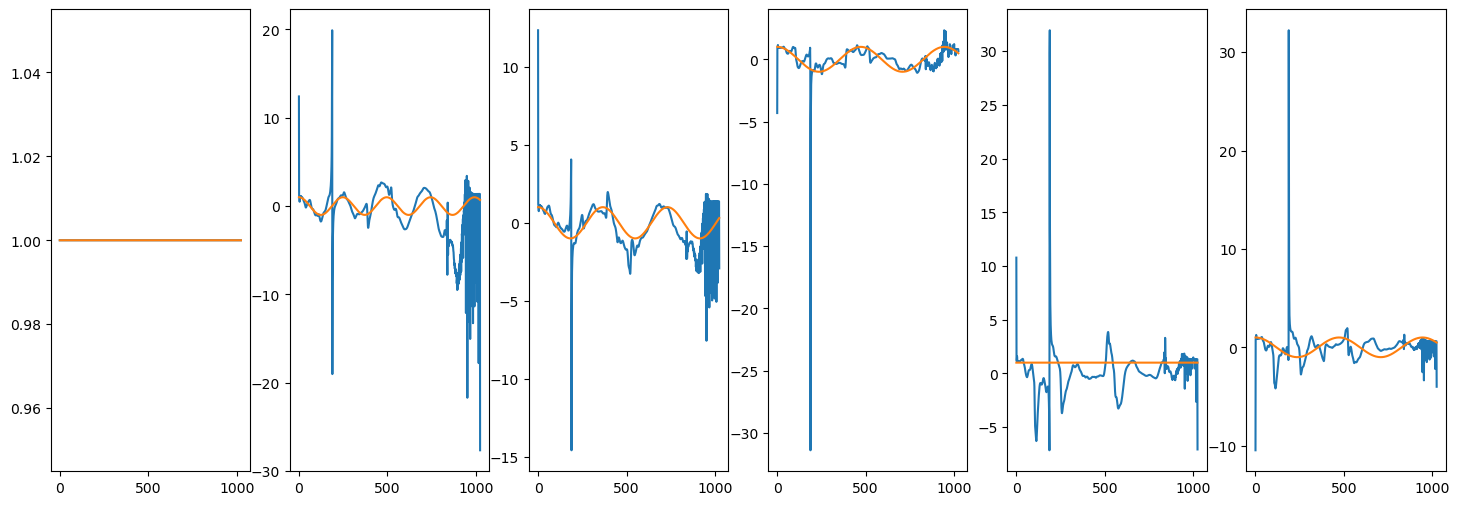

90.0 0.0


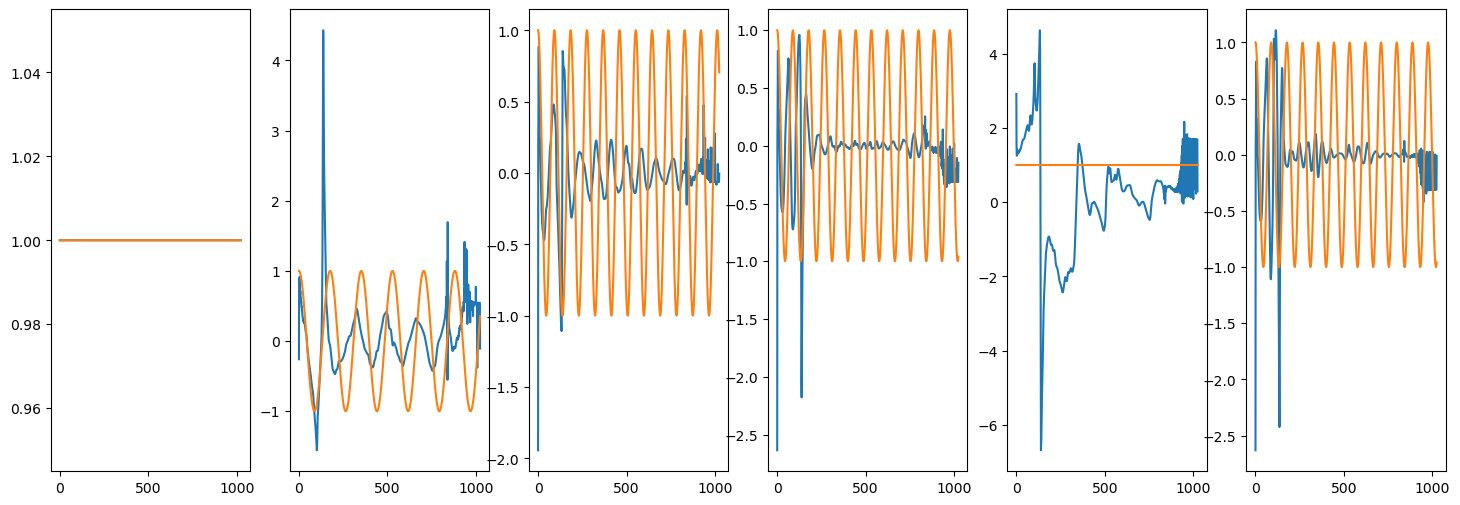

150.0 0.0


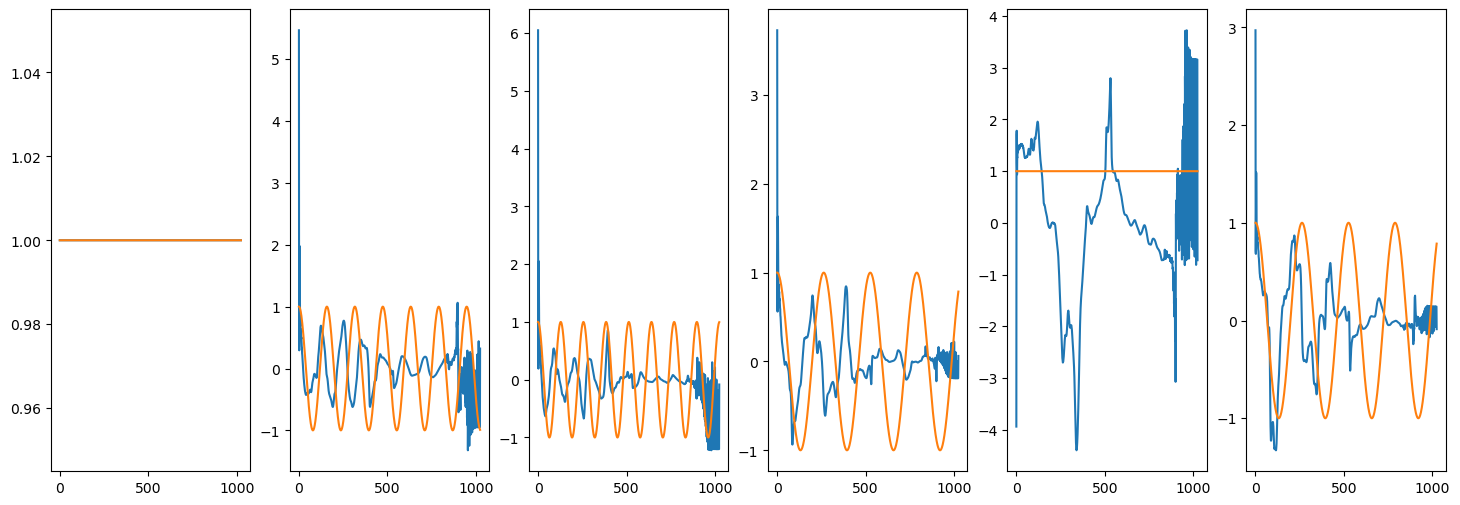

180.0 0.0


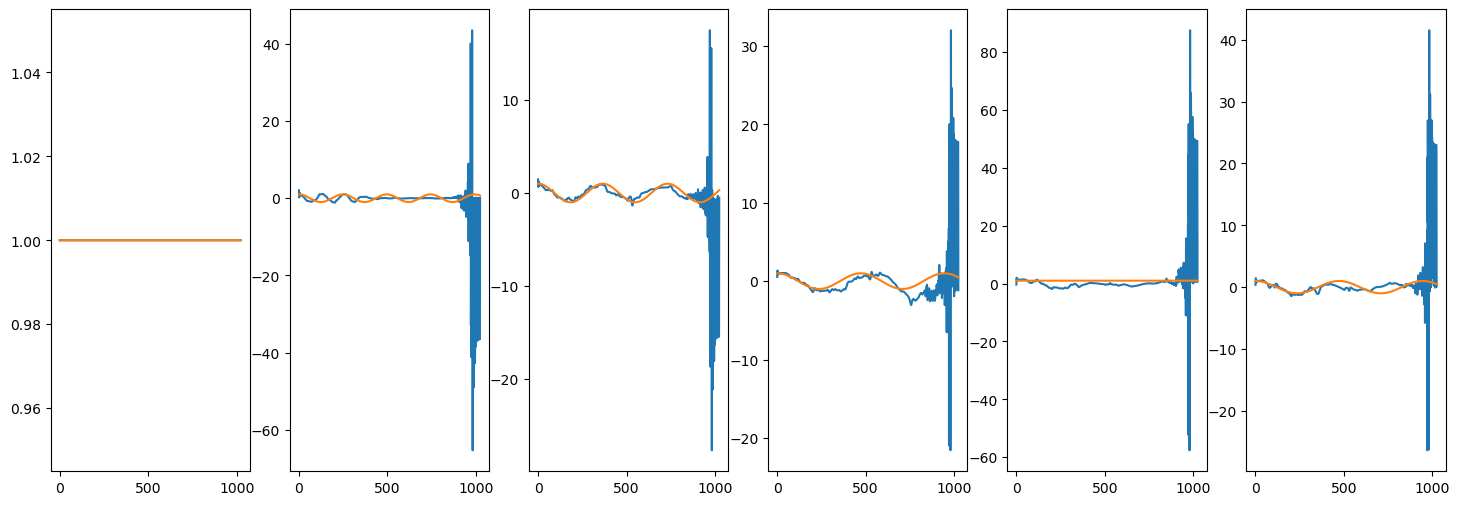

270.0 0.0


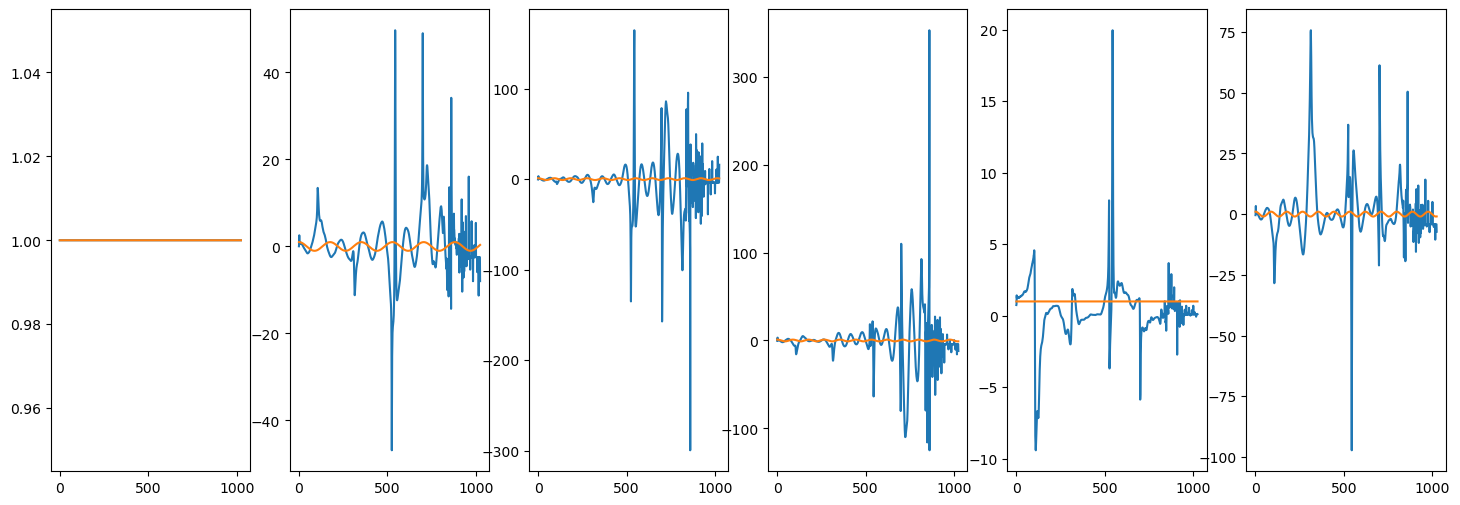

300.0 0.0


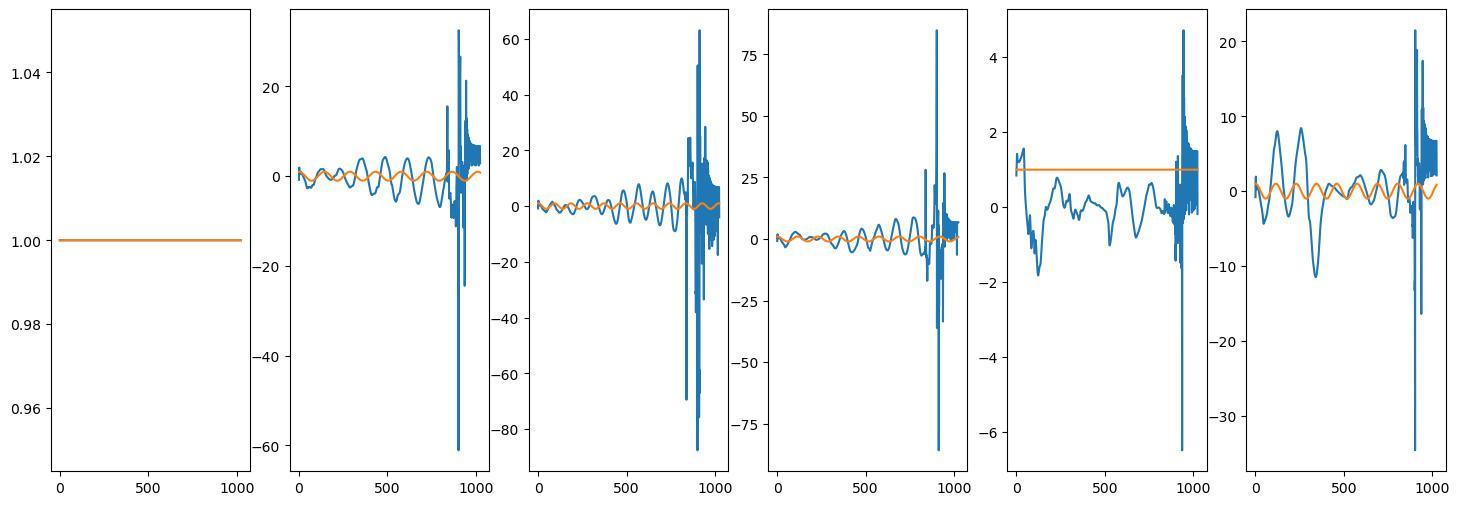

330.0 0.0


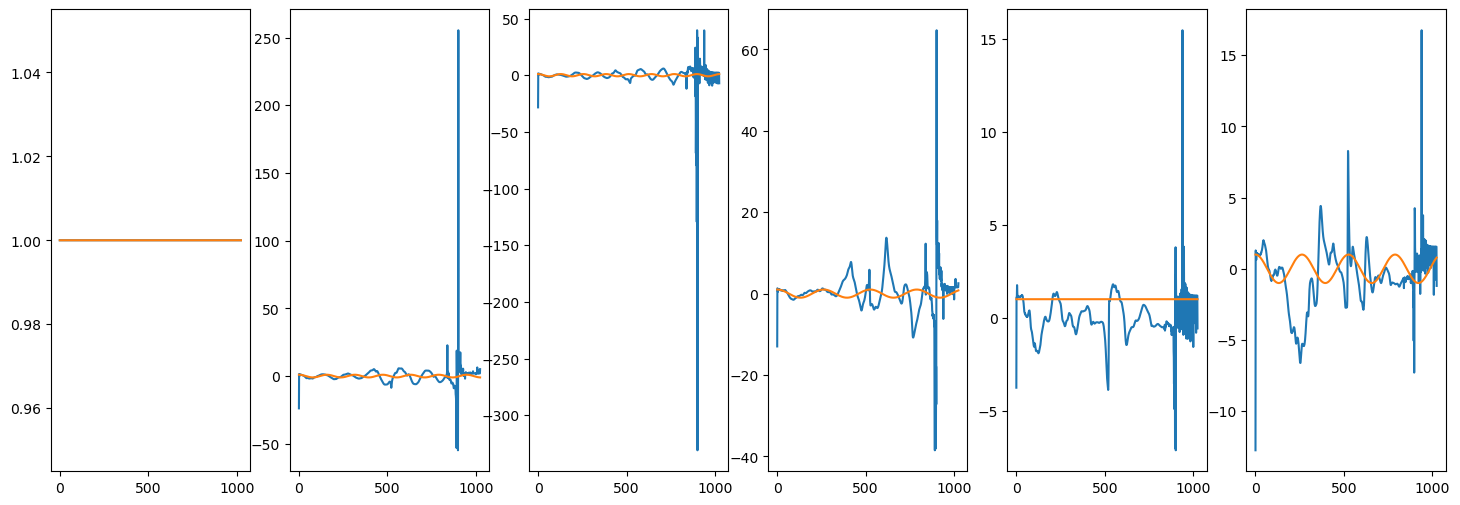

In [17]:
n = 9 + 17*38

for n in range(n_rirs):

    az, el = AIR['directions'][n,:]

    if not el == 0:
        continue

    if not np.mod(np.rad2deg(az), 30) == 0:
        continue

    print(np.rad2deg(az), np.rad2deg(el))

    rir = AIR['IR'][:,n,:]
    atf = np.fft.rfft(rir, n=2048, axis=0)

    tof_bar = 5 / fs
    freqs = np.linspace(0, 1, atf.shape[0]) * (fs/2)
    atf_d = np.exp(-1j * 2 * np.pi * tof_bar * freqs)

    # THEORETICAL MODELs
    f = np.linspace(0, fs//2, nfft//2+1,endpoint=True)
    dist_from_ref = -(R - R[:,ref_mic][:,None])
    vect_theta = geo.sph2cart(np.array([[1],[az],[el]]), deg=False) # change directiom for pointing towards the array

    # TIMEs of ARRIVAL
    toas_far_free = (vect_theta.T @  dist_from_ref) / room.c
    ## near-fieal (cartesian)
    source_pos = geo.sph2cart(np.array([[2],[az],[el]]), deg=False)
    source_pos = arr_center + source_pos
    src_to_mics_dist = np.linalg.norm(source_pos - array_pos, axis=0, keepdims=True)
    toas_cart = (src_to_mics_dist - src_to_mics_dist[:,ref_mic,None]) / room.c

    # plt.plot(np.angle(atf), label='observed phase')
    # plt.legend()
    # plt.show()

    # plt.plot(unwrap_phase(np.angle(atf)), label="observed")
    # plt.plot(unwrap_phase(np.angle(atf_d)), label="svec+offset")
    # plt.plot(unwrap_phase(np.angle(atf_wo_phase)), label="obs - (svec-offset)")
    # plt.legend()
    # plt.show()

    rtf = atf[:,None,:] / atf[:,:,None]

    svect = np.exp(-1j * 2 * np.pi * toas_far_free * freqs[:,None])
    rsvect = svect[:,None,:] / svect[:,:,None]

    fig, axarr = plt.subplots(1, n_mic, figsize=(18,6))
    r = 0
    for i, ax in enumerate(axarr):
        # ax.plot(unwrap_phase(np.angle(rtf[:,r,i])))
        # ax.plot(unwrap_phase(np.angle(rsvect[:,r,i])))
        ax.plot(rtf[:,r,i].real)
        ax.plot(rsvect[:,r,i].real)
        # ax.set_ylim([-75, 75])
    plt.show()
